<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Специализация "Машинное обучение и анализ данных"
<center>Автор материала: программист-исследователь Mail.Ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ [Юрий Кашницкий](https://yorko.github.io/)

# <center>  Capstone проект №1 <br> Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Неделя 3. Визуальный анализ данных и построение признаков

На 3 неделе мы займемся визуальным анализом данных и построением признаков. Сначала мы вместе построим и проанализируем несколько признаков, потом Вы сможете сами придумать и описать различные признаки. 

**План 3 недели:**
 - Часть 1. Построение признаков
 - Часть 2. Визуальный анализ данных
 - Часть 3. Дальнейшее построение признаков
 - Часть 4. Проверка построенных признаков

**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Поиск структуры в данных":**
   - [Задача визуализации](https://www.coursera.org/learn/unsupervised-learning/lecture/hlvlT/zadacha-vizualizatsii)
   - [Визуализация данных в sklearn](https://www.coursera.org/learn/unsupervised-learning/lecture/ityMo/vizualizatsiia-dannykh-v-sklearn)
   
**Также в задании будет использоваться библиотека Seaborn (ее можно дополнительно установить командой *pip install seaborn*), будет полезно обращаться к документациям [Matplotlib](http://matplotlib.org/users/) и [Seaborn](http://seaborn.pydata.org/), а также к примерам визуализации, описанным на StackOverflow.**



### Задание
1. Заполните код в этой тетрадке 
2. Если вы проходите специализацию Яндеса и МФТИ, пошлите тетрадку в соответствующем Peer Review. <br> Если вы проходите курс ODS, выберите ответы в [веб-форме](https://docs.google.com/forms/d/1EbjK7-hF-Gepi6RH-K5I2XeiYGRoY0LNDx03QmLu9Xo). 

## Часть 1. Построение признаков

In [1]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from glob import glob
import os
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
pd.set_option('display.max.columns', 25)
import pickle
#pip install seaborn
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
# Поменяйте на свой путь к данным
PATH_TO_DATA = 'capstone_user_identification'

**Создайте на основе функций *prepare_train_set* и *prepare_sparse_train_set_window*  новую – *prepare_train_set_with_fe*, (от "feature engineering"), создайте следующие признаки:**
- `session_timespan` – продолжительность сессии (разница между максимальным и минимальным временем посещения сайтов в сессии, в секундах)
- `#unique_sites` – число уникальных сайтов в сессии 
- `start_hour` – час начала сессии (то есть час в записи минимального timestamp среди десяти)
- `day_of_week` – день недели (то есть день недели в записи минимального timestamp среди десяти)

Функция должна возвращать новый DataFrame (как возвращала функция *prepare_train_set*), только признаков должно быть на 4 больше. Порядок, в котором добавляются признаки: *site1*, ... *site10*, *session_timespan*, *#unique_sites*, *start_hour*, *day_of_week* и *user_id* (это видно и чуть ниже по тому, как функция вызывается).

In [3]:
def calc_ranges(last_arg, length, window_size):
    user_list = []
    i = 1
    while True:
        
        a = list(range(i, i + length))
        user_list.append(a)
        i += window_size
        
        if i  > last_arg+1:
            break
            
    return user_list

In [4]:
def prepare_train_set_with_fe(path_to_csv_files, site_freq_path, feature_names,
                                    session_length=10, window_size=10):
        #считаем файлы в папке
    tmp = glob(path_to_csv_files)
    list_files = []
    numers = []
    for idx, obj in enumerate(tmp):
        list_files.append(pd.read_csv(obj))
        list_files[idx].timestamp = pd.to_datetime(list_files[idx].timestamp)
        numers.append(int(obj[-8:-4]))
        
    pkl_file = open(site_freq_path, 'rb')
    freq = pickle.load(pkl_file)
    sessions = []
    session = []
    time_difference = []

    for num, user in zip(numers, list_files):
        user_range = calc_ranges(user.index[-1], session_length, window_size)
        for rng in user_range:
            
            tmp = list(map(lambda x: x-1, rng))
            session = [freq[user.site[x]][0] if x < len(user) else 0 for x in tmp]
            difference = [(user.timestamp[tmp[i]] - user.timestamp[tmp[i-1]]).total_seconds() 
                          if tmp[i] < len(user) else 0  for i in range(1, len(tmp))]
            unique_count = len(np.unique(session)) if tmp[-1] < len(user) else len(np.unique(session))-1
            difference = np.hstack((difference, [sum(difference), unique_count, 
                                                 user.timestamp[tmp[0]].hour, user.timestamp[tmp[0]].weekday(), num]))
            sessions.append(np.hstack((session, difference)))
            session_timespan = user.index[0]
 
    

    columns = ['site' + str(i) for i in range(1,11)] + \
                ['time_diff' + str(j) for j in range(1,10)] + \
                  ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'target']
    
    df = pd.DataFrame(sessions, columns = columns) 
    return  df

**Проверим функцию на игрушечном примере.**

In [5]:
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['time_diff' + str(j) for j in range(1,10)]

train_data_toy  = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '3users/*'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_3users.pkl'),
                  feature_names=feature_names, session_length=10)

In [6]:
train_data_toy

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,1.0,2.0,2.0,3.0,2.0,4.0,5.0,6.0,7.0,8.0,287.0,1184.0,6278.0,186.0,2.0,1.0,2.0,3.0,55.0,7998.0,8.0,9.0,4.0,1.0
1,1.0,4.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,3.0,55.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0,2.0,12.0,4.0,1.0
2,1.0,2.0,9.0,9.0,2.0,0.0,0.0,0.0,0.0,0.0,287.0,1184.0,6278.0,186.0,0.0,0.0,0.0,0.0,0.0,7935.0,3.0,9.0,4.0,2.0
3,10.0,4.0,2.0,4.0,2.0,4.0,4.0,6.0,11.0,10.0,287.0,1184.0,6278.0,186.0,2.0,1.0,2.0,3.0,55.0,7998.0,5.0,9.0,4.0,3.0
4,10.0,4.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,287.0,1184.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1471.0,3.0,12.0,4.0,3.0


In [7]:
train_data_toy

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,1.0,2.0,2.0,3.0,2.0,4.0,5.0,6.0,7.0,8.0,287.0,1184.0,6278.0,186.0,2.0,1.0,2.0,3.0,55.0,7998.0,8.0,9.0,4.0,1.0
1,1.0,4.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,3.0,55.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0,2.0,12.0,4.0,1.0
2,1.0,2.0,9.0,9.0,2.0,0.0,0.0,0.0,0.0,0.0,287.0,1184.0,6278.0,186.0,0.0,0.0,0.0,0.0,0.0,7935.0,3.0,9.0,4.0,2.0
3,10.0,4.0,2.0,4.0,2.0,4.0,4.0,6.0,11.0,10.0,287.0,1184.0,6278.0,186.0,2.0,1.0,2.0,3.0,55.0,7998.0,5.0,9.0,4.0,3.0
4,10.0,4.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,287.0,1184.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1471.0,3.0,12.0,4.0,3.0


**Примените функцию *prepare_train_set_with_fe* к данным по 10 пользователям, укажите *session_length*=10.**

In [8]:
%%time
train_data_10users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '10users/*'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_10users.pkl'),
                  feature_names=feature_names, session_length=10)

Wall time: 11.5 s


In [9]:
train_data_10users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,1.0,2.0,3.0,4.0,3.0,3.0,4.0,3.0,5.0,3.0,10.0,0.0,0.0,1.0,20.0,1.0,0.0,1.0,0.0,33.0,5.0,8.0,4.0,31.0
1,6.0,7.0,8.0,9.0,3.0,10.0,11.0,12.0,13.0,14.0,1.0,0.0,163.0,105.0,0.0,1.0,3.0,3.0,8.0,284.0,10.0,8.0,4.0,31.0
2,14.0,4.0,14.0,14.0,15.0,16.0,6.0,17.0,18.0,14.0,0.0,14.0,1.0,242.0,0.0,0.0,1.0,0.0,0.0,258.0,7.0,8.0,4.0,31.0
3,19.0,20.0,19.0,14.0,14.0,14.0,14.0,21.0,22.0,23.0,2.0,1.0,0.0,1.0,25.0,1.0,0.0,0.0,0.0,30.0,6.0,8.0,4.0,31.0
4,24.0,14.0,15.0,25.0,26.0,27.0,28.0,29.0,30.0,29.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,6.0,9.0,8.0,4.0,31.0


**Примените функцию *prepare_train_set_with_fe* к данным по 150 пользователям, укажите *session_length*=10.**

In [10]:
%%time
train_data_150users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '150users/*'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_150users.pkl'),
                  feature_names=feature_names, session_length=10)

Wall time: 1min 59s


**Сохраните в pickle-файлы признаки *session_timespan*, *#unique_sites*, *start_hour* и *day_of_week* для 10 и 150 пользователей.**

In [11]:
new_features_10users = train_data_10users[train_data_10users.columns[-5:-1]]
new_features_150users = train_data_150users[train_data_10users.columns[-5:-1]]

In [12]:
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_10users.pkl'), 'wb') as new_features_10users_pkl:
    pickle.dump(new_features_10users, new_features_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_150users.pkl'), 'wb') as new_features_150users_pkl:
    pickle.dump(new_features_150users, new_features_150users_pkl)

**<font color='red'>Вопрос 1. </font> Выведите медианную продолжительность сессии (*session_timespan*) для сессий 10 пользователей.**

In [13]:
new_features_10users

,session_timespan,#unique_sites,start_hour,day_of_week
0,33.0,5.0,8.0,4.0
1,284.0,10.0,8.0,4.0
2,258.0,7.0,8.0,4.0
3,30.0,6.0,8.0,4.0
4,6.0,9.0,8.0,4.0
...,...,...,...,...
14056,27.0,8.0,15.0,2.0
14057,11.0,8.0,15.0,2.0
14058,16.0,6.0,15.0,2.0
14059,242.0,5.0,15.0,2.0


In [14]:
print("Медианная продолжительность сессии: ", 
      np.median(new_features_10users.session_timespan))

Медианная продолжительность сессии:  37.0


**<font color='red'>Вопрос 2. </font> Выведите медианный день недели, в который началась сессия, для сессий 10 пользователей.**

In [15]:
print("Медианный день недели: ", 
      np.median(new_features_10users.day_of_week))

Медианный день недели:  2.0


**<font color='red'>Вопрос 3. </font>Выведите медианный час начала сессии для сессий 150 пользователей.**

In [16]:
print("Медианный час начала сессии: ", 
      np.median(new_features_150users.start_hour)) 

Медианный час начала сессии:  13.0


**<font color='red'>Вопрос 4. </font>Выведите медианное значение числа уникальных сайтов в сессиях 150 пользователей.**

In [17]:
print("медианное значение числа уникальных сайтов: ", 
      np.median(new_features_150users["#unique_sites"])) 

медианное значение числа уникальных сайтов:  7.0


## Часть 2. Визуальный анализ данных

**Забавы ради, потехи для дадим пользователям имена и ассоциируем с ними цвета.**

In [18]:
id_name_dict = {128: 'Mary-Kate', 39: 'Ashley', 207: 'Lindsey', 127: 'Naomi', 237: 'Avril',
               33: 'Bob', 50: 'Bill', 31: 'John', 100: 'Dick', 241: 'Ed'}
train_data_10users['user_id'] = train_data_10users['target'].map(id_name_dict)

In [19]:
color_dic = {'Mary-Kate': 'pink', 'Ashley': 'darkviolet', 'Lindsey':'blueviolet', 
             'Naomi': 'hotpink', 'Avril': 'orchid', 
             'Bob': 'firebrick', 'Bill': 'gold', 'John': 'forestgreen', 
             'Dick': 'slategrey', 'Ed':'brown'}

**1. Постройте гистограмму распределения длины сессии в секундах (*session_timespan*). Ограничьте по *x* значением 200 (иначе слишком тяжелый хвост). Сделайте гистограмму цвета *darkviolet*, подпишите оси по-русски.**

Text(0, 0.5, 'количество сессий')

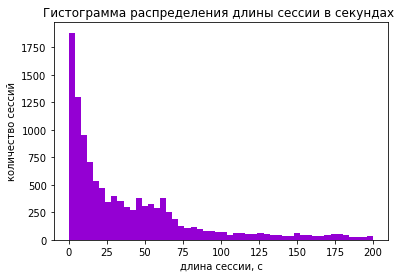

In [20]:
plt.hist(train_data_10users['session_timespan'], bins=50, 
         range=(0,200), color="darkviolet")
plt.title("Гистограмма распределения длины сессии в секундах ")
plt.xlabel("длина сессии, с")
plt.ylabel("количество сессий")

**2. Постройте гистограмму распределения числа уникальных сайтов в сессии (*#unique_sites*). Сделайте гистограмму цвета *aqua*, подпишите оси по-русски.**

Text(0, 0.5, 'количество сессий')

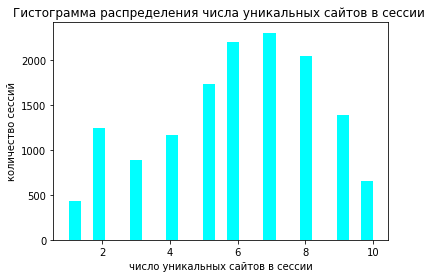

In [21]:
plt.hist(train_data_10users['#unique_sites'], bins=25, 
         color="aqua")
plt.title("Гистограмма распределения числа уникальных сайтов в сессии ")
plt.xlabel("число уникальных сайтов в сессии")
plt.ylabel("количество сессий")

**3. Постройте гистограммы распределения числа уникальных сайтов в сессии (*#unique_sites*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

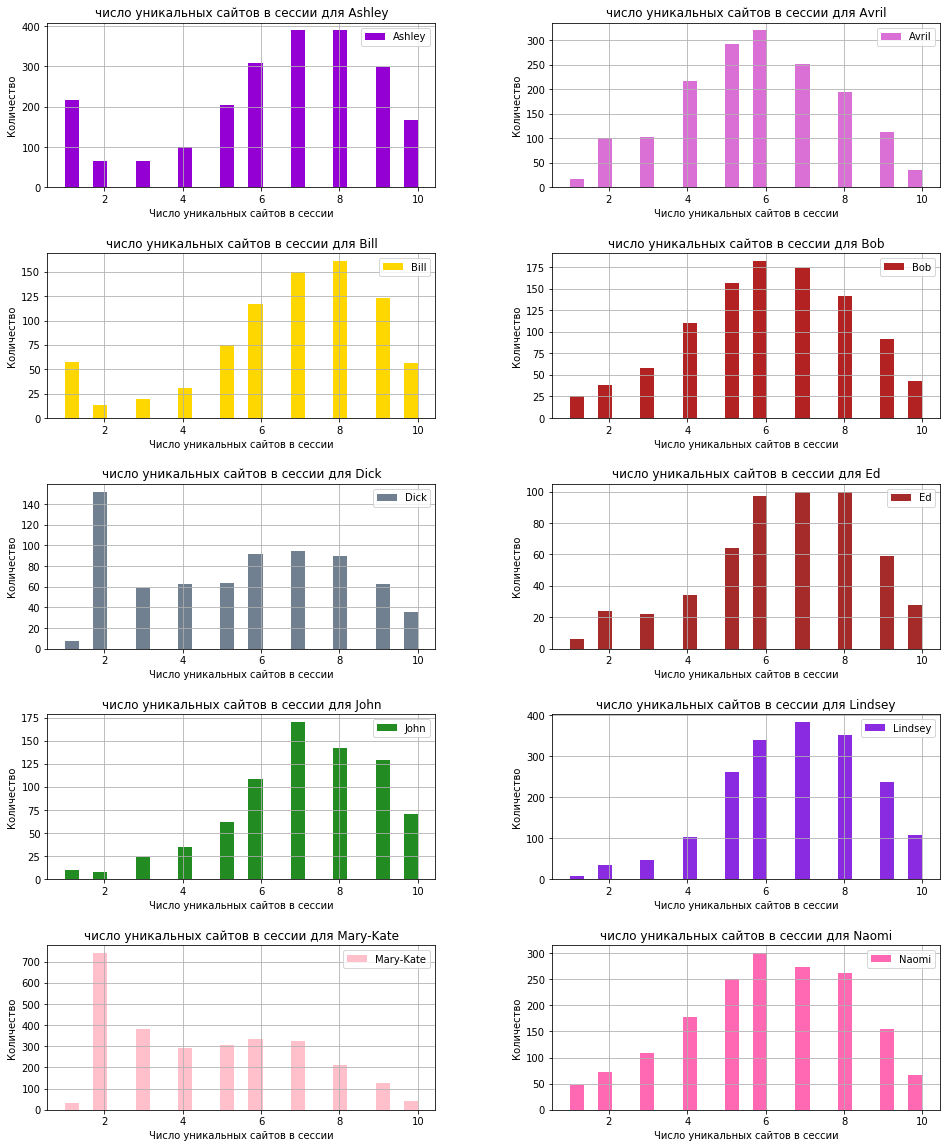

In [22]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(16, 20))
plt.subplots_adjust( wspace=.3, hspace=.4)

# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(train_data_10users.groupby(by=["user_id"])["#unique_sites"]): 
    subplot = axes[idx//2, idx%2]
    subplot.hist(sub_df, 25, facecolor=color_dic[user])
    subplot.title.set_text(f"число уникальных сайтов в сессии для {user}")
    subplot.legend((user, ))
    subplot.yaxis.label.set_text('Количество')
    subplot.xaxis.label.set_text('Число уникальных сайтов в сессии')
    subplot.grid(True)

**4. Постройте гистограмму распределения часа начала сессии (*start_hour*). Сделайте гистограмму цвета *darkgreen*, подпишите оси по-русски.**

Text(0, 0.5, 'количество сессий')

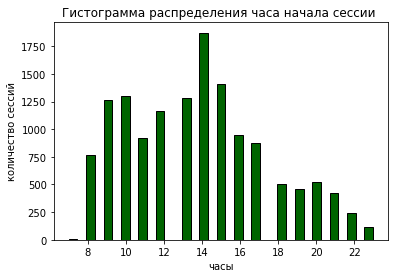

In [23]:
plt.hist(train_data_10users['start_hour'], bins=35, edgecolor="black",
         color="darkgreen")
plt.title("Гистограмма распределения часа начала сессии ")
plt.xlabel("часы")
plt.ylabel("количество сессий")

**5. Постройте гистограммы распределения часа начала сессии (*start_hour*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

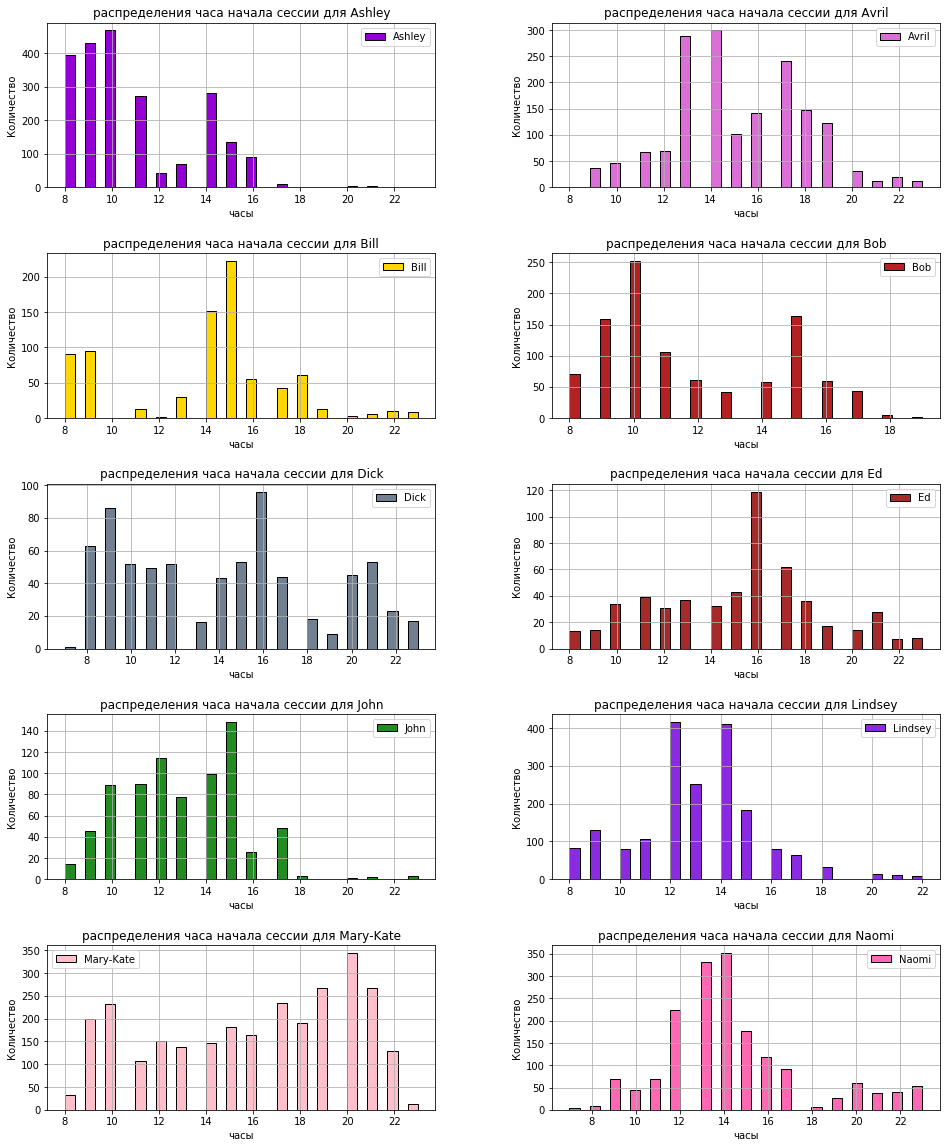

In [24]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(16, 20))
plt.subplots_adjust( wspace=.3, hspace=.4)

# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(train_data_10users.groupby(by=["user_id"])["start_hour"]): 
    subplot = axes[idx//2, idx%2]
    subplot.hist(sub_df, 35, edgecolor="black", facecolor=color_dic[user])
    subplot.title.set_text(f"распределения часа начала сессии для {user}")
    subplot.legend((user, ))
    subplot.yaxis.label.set_text('Количество')
    subplot.xaxis.label.set_text('часы')
    subplot.grid(True)

**6. Постройте гистограмму распределения дня недели, в который началась сессия (*day_of_week*). Сделайте гистограмму цвета *sienna*, подпишите оси по-русски.**

Text(0, 0.5, 'количество сессий')

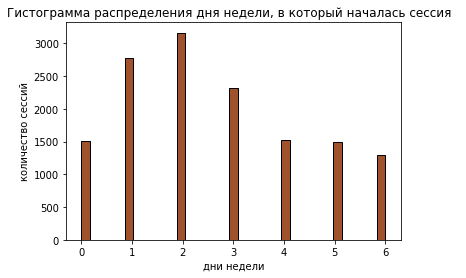

In [25]:
plt.hist(train_data_10users['day_of_week'], bins=35, edgecolor="black",
         color="sienna")
plt.title("Гистограмма распределения дня недели, в который началась сессия  ")
plt.xlabel("дни недели")
plt.ylabel("количество сессий")

**7. Постройте гистограммы распределения дня недели, в который началась сессия (*day_of_week*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Измените метки по оси *X* на ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'] – метод *set_xticklabels*. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите по-русски название каждой из 10 гистограмм.**

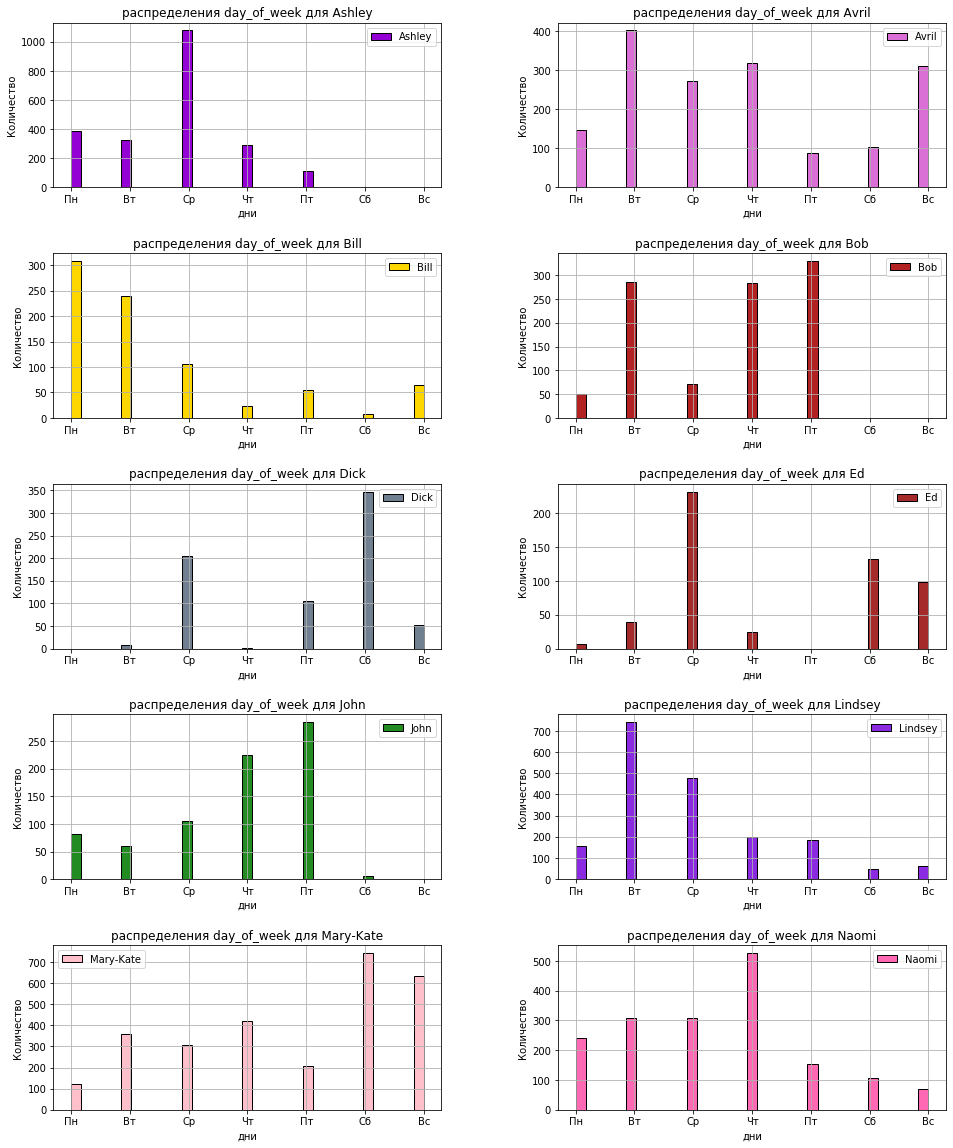

In [26]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(16, 20))
plt.subplots_adjust( wspace=.3, hspace=.4)

# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(train_data_10users.groupby(by=["user_id"])["day_of_week"]): 
    subplot = axes[idx//2, idx%2]
    subplot.hist(sub_df, 35, range=(0, 6), edgecolor="black", facecolor=color_dic[user])
    subplot.title.set_text(f"распределения day_of_week для {user}")
    subplot.legend((user, ))
    subplot.yaxis.label.set_text('Количество')
    subplot.xaxis.label.set_text('дни')
    subplot.set_xticklabels([0, 'Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'])
    subplot.grid(True)

**8. Сделайте выводы про каждого пользователя по построенным графикам.**

    1. Ashley
    Для Ashley характерно заходить на конкретный сайт или же использовать много сайтов в одну сессию(> 4 уникальных сайтов).
    Пользователь активно заходит на сайты в рабочее время(начинает новые сессии) и наоборот совсем не пользуется в свободное время(12-14/16-24).Сессии приходятся на рабочие дни недели, в выходные активность отсутствует. 
    2. Avril
    Avril активно использует сразу несколько уникальных сайтов в сессию.Всплески активности приходятся на нерабочие часы.В вечернее и ночное время интеснивность создания сессий снижается. Наибольшее количество сессий в день приходятся на Вт и Вс,хотя в другие дни недели Avril остается активным пользователем
    3. Bill
    Распределение числа уникальных сайтов схоже с распределением для Ashley, отличаясь только абсолютными значениями колимчества сессий(для Билла примерно в 2 раза меньше).Активен с 8 до 10 и с 14 до 18(всплеск активности).Наиболее интенсивно пользуется интернетом в первую половину недели,но имеет активность и в выходные
    4. Bob
    Распределение числа уникальных сайтов схоже с распределением для Avril, отличаясь только абсолютными значениями колимчества сессий(для Боба примерно в 2 раза меньше).Активен весь рабочий день,но наибольшее количество сессий приходится на 10 часов.Боб работает с Пн по Пт,а наиболее загруженные дни Вт, Чт, Пт
    5. Dick
    Распределение уникальных сайтов отличается от общего распределдения.Модой распределения является 2.Количество сессий с количество уникальных сайтов в интервале от 3х до 10 примерно одинаково, хотя сессии с {6, 7, 8} сайтами встречаются чаще.Периоды наибольшей активности с 8 до 12, с 14 до 17 и с 20 до 22х с наибольшим количеством сессий в 9, 16, 21 ч соответственно.Dick не имеет активности в Пн совсем и почти в Вт и Чт, в Ср и Сб наиболее активен.
    6. Ed
    Чаще всего в сессии много уникальных сайтов, но сессии с {6, 7, 8} сайтами встречаются наиболее часто.Общее количество сессий небольшое, дневная активность отличается всплеском в 16-17 ч, в остальные часы количество начатых сессий принимает похожие значения. Не имеет активности в Пт совсем, в Пн почти, в Ср,Сб,Вс наиболее активен
    7. John
    В сессии обыкновенно много уникальных сайтов, мода распределения 7. Активен в рабочие часы с 8-18 и соответственно в рабочие дни с Пн-Пт,в Пт пик активности,немного пользуется интернетом в Сб.
    8. Lindsey
    Большое количество сессий, мода распределения уникальных сайтов в сессии 7.Распределение часа начала сессии бимодальное(12, 14).Активна всю неделю,но Вт самый загруженный день, также Ср выделяется на общем фоне.
    9. Mary-Kate
    Большое количество сессий. Распределение числа уникальных сайтов отличается от общего, мода текущего распределения 2. Распределение часа начала сессии атипичное, мода распределения 20ч. Активна всю неделю, но Сб и Вс самые загруженные дни.
    10. Naomi
    Большое число сессий. Число уникальных сайтов в сессии чаще всего принимает значение 6. Пик активности с 12-15, активна всю неделю, но Чт самый загруженный день

**Загрузите сохраненный ранее в pickle-файл частотный словарь сайтов для 10 пользователей. **

In [27]:
with open(os.path.join(PATH_TO_DATA, 'site_freq_10users.pkl'), 'rb') as file:
    top_dict = pickle.load(file)

**Определите топ-10 самых посещаемых сайтов (*top10_sites*) и соответствующие кол-ва посещений (*top10_freqs*).**

In [28]:
top10_freqs =  list(v[1] for k, v in sorted(top_dict.items(), key=lambda x: x[1][1], reverse=True))[:10]
top10_sites =  list(k for k, v in sorted(top_dict.items(), key=lambda x: x[1][1], reverse=True))[:10]

**9. Нарисуйте *seaborn barplot*, показывающий частоты посещений топ-10 сайтов. Сделайте подписи сайтов вертикальными, иначе они сливаются (*xticks*).**

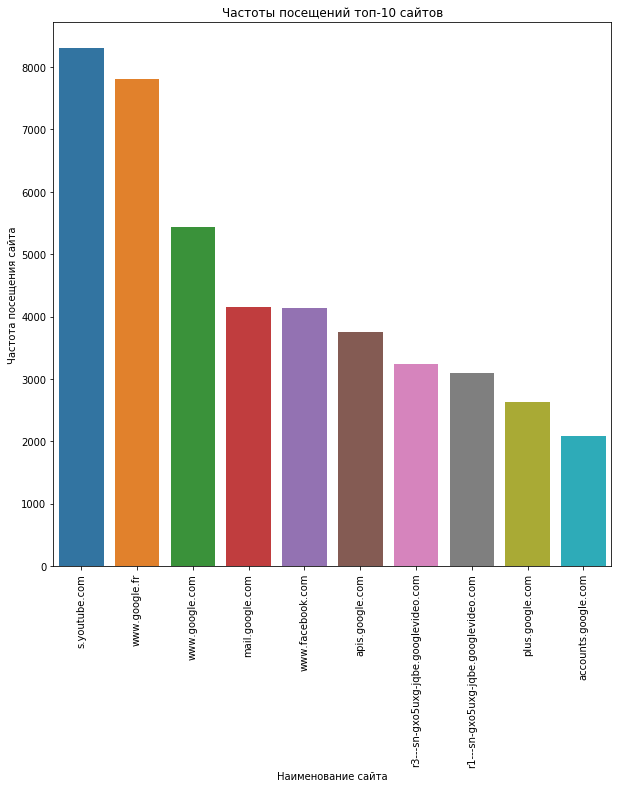

In [29]:
plt.figure(figsize=(10, 10))
plt.title('Частоты посещений топ-10 сайтов')
ax = sns.barplot(top10_sites, top10_freqs)
ax.set(xlabel="Наименование сайта", ylabel='Частота посещения сайта')
plt.setp(ax.get_xticklabels(), rotation=90)
plt.show()

## Часть 3. Дальнейшее построение признаков

Это задание творческое, тут надо придумать, как еще учесть время посещения веб-страниц и прочие признаки. 

На следующей неделе мы будем использовать "мешок" сайтов  для классификации сессий по принадлежности разным пользователям, а эти новые признаки, которые Вы сейчас создадите, потом добавим и посмотрим, улучшается ли модель. Поэтому можно их создать в виде отдельных матриц и сохранить их также отдельно.  

В этой части задания Вы можете построить и визуально исследовать самые разные признаки (ничто фантазию не ограничивает):
- год, месяц и день начала сессии
- час начала сессии (с учетом года, месяца и дня)
- время суток
- среднее время пребывания на сайте, посчитать можно, скажем, для топ-30 популярных сайтов
- индикаторы посещения популярных сайтов (скажем, тоже для топ-30 популярных сайтов)
- частота посещения Facebook
- ...

**Напишите функцию для создания новых признаков и примените ее к исходным данным – каталогам с 10 и 150 файлами. Сделайте это только для набора данных, полученного с параметрами *session_length=10* и *window_size=10*. Сериализуйте полученные матрицы с помощью pickle. Функция может возвращать как только новые признаки, так и старые с новыми. При этом сигнатура функции может быть другой – тут уже свобода выбора.**

In [30]:
top30_freqs =  list(v[1] for k, v in sorted(top_dict.items(), key=lambda x: x[1][1], reverse=True))[:30]
top30_sites =  list(v[0] for k, v in sorted(top_dict.items(), key=lambda x: x[1][1], reverse=True))[:30]

In [31]:
def feature_engineering(path_to_csv_files, site_freq_path,
                                    session_length=10, window_size=10):

    tmp = glob(path_to_csv_files)
    list_files = []
    numers = []
    for idx, obj in enumerate(tmp):
        list_files.append(pd.read_csv(obj))
        list_files[idx].timestamp = pd.to_datetime(list_files[idx].timestamp)
        numers.append(int(obj[-8:-4]))
        
    pkl_file = open(site_freq_path, 'rb')
    freq = pickle.load(pkl_file)
    sessions = []
    

    for num, user in zip(numers, list_files):
        user_range = calc_ranges(user.index[-1], session_length, window_size)
        for rng in user_range:
            session = []
            new_features = []
            tmp = list(map(lambda x: x-1, rng))
            for i, x in enumerate(tmp):
                if x < len(user):
                    session.append(freq[user.site[x]][0])
                    if freq[user.site[x]][0] in top30_sites:
                        if i+1 < len(tmp) and tmp[i+1] < len(user):
                            new_features.append((user.timestamp[tmp[i+1]] - user.timestamp[tmp[i]]).total_seconds())
                    

                else:
                    session.append(0)
                    new_features.append(0)
                    
            flags = 1 if len(new_features) > 0 else 0
            average = np.mean(new_features)
            sessions.append(np.hstack((session, [average, flags])))
            session_timespan = user.index[0]
 
    

    columns = ['site' + str(i) for i in range(1,11)] + \
                ["average time", "visit top30"]
    
    df = pd.DataFrame(sessions, columns = columns) 
    return  df

In [32]:
train_data_10users_new = feature_engineering(os.path.join(PATH_TO_DATA, 
                                                         '10users/*'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_10users.pkl'))

In [33]:
train_data_10users_new.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,average time,visit top30
0,1.0,2.0,3.0,4.0,3.0,3.0,4.0,3.0,5.0,3.0,0.5,1.0
1,6.0,7.0,8.0,9.0,3.0,10.0,11.0,12.0,13.0,14.0,NaN,0.0
2,14.0,4.0,14.0,14.0,15.0,16.0,6.0,17.0,18.0,14.0,7.0,1.0
3,19.0,20.0,19.0,14.0,14.0,14.0,14.0,21.0,22.0,23.0,NaN,0.0
4,24.0,14.0,15.0,25.0,26.0,27.0,28.0,29.0,30.0,29.0,1.0,1.0


In [35]:
new_features_10users = feature_engineering(os.path.join(PATH_TO_DATA, 
                                                         '10users/*'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_10users.pkl'))

In [36]:
new_features_150users = feature_engineering(os.path.join(PATH_TO_DATA, 
                                                         '150users/*'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_150users.pkl'))

**10. Постройте картинки для новых признаков, поисследуйте их, прокомментируйте результаты.**

Text(0, 0.5, 'количество сессий')

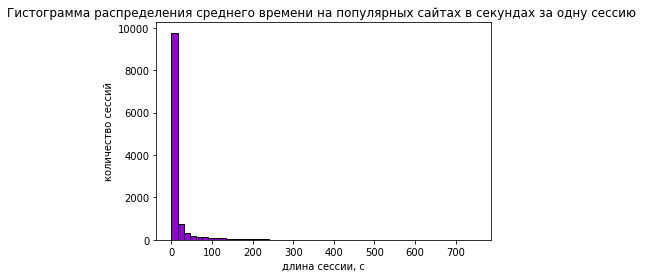

In [40]:
plt.hist(train_data_10users_new['average time'], bins=50, 
         range=(0,750), edgecolor="black", color="darkviolet")
plt.title("Гистограмма распределения среднего времени на популярных сайтах в секундах за одну сессию ")
plt.xlabel("длина сессии, с")
plt.ylabel("количество сессий")

In [38]:
train_data_10users_new['user_id'] = train_data_10users['target'].map(id_name_dict)

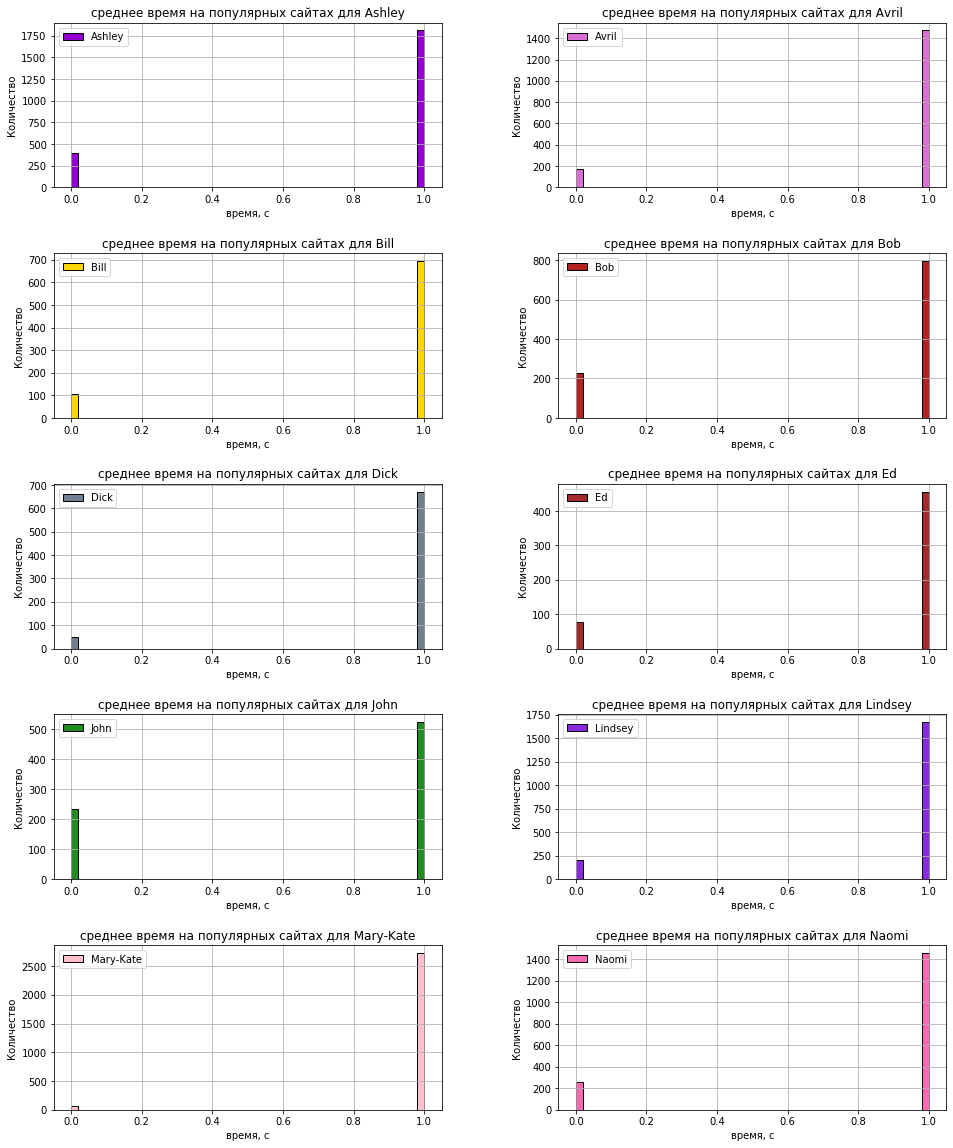

In [39]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(16, 20))
plt.subplots_adjust( wspace=.3, hspace=.4)

# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(train_data_10users_new.groupby(by=["user_id"])["visit top30"]): 
    subplot = axes[idx//2, idx%2]
    subplot.hist(sub_df, 50, facecolor=color_dic[user], edgecolor="black")
    subplot.title.set_text(f"среднее время на популярных сайтах для {user}")
    subplot.legend((user, ))
    subplot.yaxis.label.set_text('Количество')
    subplot.xaxis.label.set_text('время, с')
    subplot.grid(True)

* теперь мы можем посмотреть долю популярных сайтов для пользователей и их среднее время пребывания на них,но среднее время только за одну сессию

**В конце сохраните в pickle-файлы только те признаки, которые, как Вы предполагаете, помогут идентифицировать пользователя более точно. Это касается и признаков, которые мы вместе создали в начале (*session_timespan, #unique_sites, start_hour, day_of_week*), и Ваших собственных. Можно создать все эти признаки не только для сессий из 10 сайтов, но и для других сочетаний параметров *session_length* и *window_size*.**

In [42]:
selected_features_10users = pd.concat([train_data_10users[feature_names], train_data_10users_new[["average time", "visit top30"]]],axis=1)
selected_features_150users = pd.concat([train_data_150users[feature_names], new_features_150users[["average time", "visit top30"]]],axis=1) 

In [43]:
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_10users.pkl'), 'wb') as selected_features_10users_pkl:
    pickle.dump(selected_features_10users, selected_features_10users_pkl, 
                protocol=2)
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_150users.pkl'), 'wb') as selected_features_150users_pkl:
    pickle.dump(selected_features_150users, selected_features_150users_pkl, 
                protocol=2)

### Критерии оценки работы (только для Peer Review в специализации):
- Верно ли отображена гистограмма session_timespan из п. 1? (max. 3 балла)
- Верно ли отображена гистограмма #unique_sites из п. 2? (max. 3 балла)
- Верно ли отображены гистограммы #unique_sites по каждому пользователю из п. 3? (max. 6 баллов)
- Верно ли отображена гистограмма start_hour из п. 4? (max. 3 балла)
- Верно ли отображены гистограммы start_hour по каждому пользователю из п. 5? (max. 6 баллов)
- Верно ли отображена гистограмма day_of_week из п. 6? (max. 3 балла)
- Верно ли отображены гистограммы day_of_week по каждому пользователю из п. 7? (max. 6 баллов)
- Насколько сделанные выводы в п. 8 соответствуют построенным картинкам? (max. 6 баллов)
- Верно ли отображен barplot для 10 популярных сайтов из п. 9? (max. 6 баллов)
- Правильно ли посчитана медианная продолжительность сессий в п. 10? (max. 3 балла)
- Правильно ли посчитан медианный день недели начала сессии в п. 11? (max. 3 балла)
- Правильно ли посчитан медианный час начала сессии в п. 12? (max. 3 балла)
- Правильно ли посчитано медианное значение числа уникальных сайтов в сессиях 150 пользователей п. 13? (max. 3 балла)
- Есть ли оригинальные построенные признаки и картинки к ним? Оцените также и качество картинок. (max. 8 баллов)

## Пути улучшения
Что еще можно добавить по 3 части проекта:
- IPython-widgets, интерактив и анимация (стоящие статьи по этому ремеслу – [раз](https://habrahabr.ru/post/308162/) и  [два](https://habrahabr.ru/company/ods/blog/323210/))
- можно попробовать изобразить исходные данные в некотором пространстве, например, Word2Vec, потом выделить главные компоненты или t-SNE  (только пользуйтесь эффективными реализациями типа [Multicore-TSNE](https://github.com/DmitryUlyanov/Multicore-TSNE), не Sklearn) и раскрасить по целевому классу. Но нет гарантий, что получится что-то значимо отличающееся от каши

На следующей неделе мы наконец приступим к обучению моделей классификации. 